# Parallel node execution


## Fan out and fan in



In [1]:
%%capture --no-stderr
%pip install -U  langgraph tavily-python wikipedia langchain_openai langchain_community langgraph_sdk

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

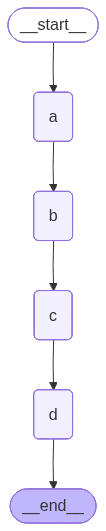

In [3]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

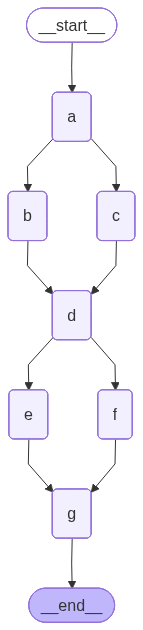

In [5]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))
builder.add_node("f", ReturnNodeValue("I'm F"))
builder.add_node("g", ReturnNodeValue("I'm G"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", "e")
builder.add_edge("d", "f")
builder.add_edge("e", "g")
builder.add_edge("f", "g")
builder.add_edge("g", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


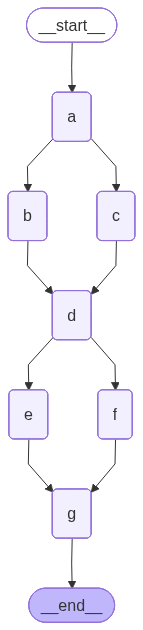

In [7]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))
builder.add_node("f", ReturnNodeValue("I'm F"))
builder.add_node("g", ReturnNodeValue("I'm G"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", "e")
builder.add_edge("d", "f")
builder.add_edge("e", "g")
builder.add_edge("f", "g")
builder.add_edge("g", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]
Adding I'm E to ["I'm A", "I'm B", "I'm C", "I'm D"]
Adding I'm F to ["I'm A", "I'm B", "I'm C", "I'm D"]
Adding I'm G to ["I'm A", "I'm B", "I'm C", "I'm D", "I'm E", "I'm F"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D", "I'm E", "I'm F", "I'm G"]}

## Waiting for nodes to finish

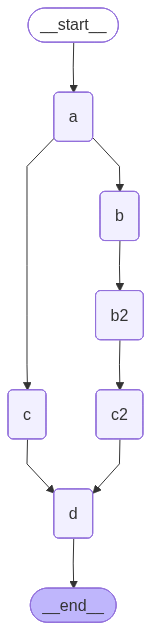

In [9]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("c2", ReturnNodeValue("I'm C2"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge("b2", "c2")
builder.add_edge(["c2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm C2 to ["I'm A", "I'm B", "I'm C", "I'm B2"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm C2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm C2", "I'm D"]}

## Setting the order of state updates


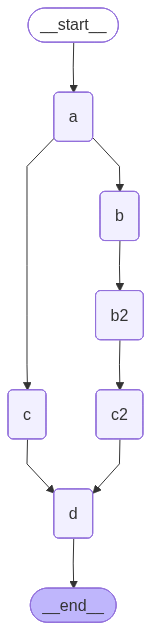

In [11]:
def sorting_reducer(left, right):
    """ Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]
    
    return sorted(left + right, reverse=False)

class State(TypedDict):
    # sorting_reducer will sort the values in state
    state: Annotated[list, sorting_reducer]

# Add nodes
builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("c2", ReturnNodeValue("I'm C2"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge("b2", "c2")
builder.add_edge(["c2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm C2 to ["I'm A", "I'm B", "I'm B2", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm C2"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm C2", "I'm D"]}

Now, the reducer sorts the updated state values!



## Working with LLMs


In [13]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [14]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

In [15]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")

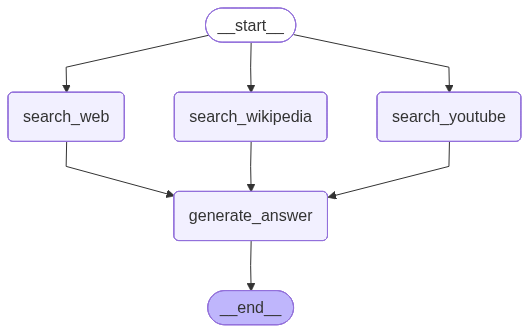

In [21]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults
from langchain_community.tools import YouTubeSearchTool
import json

def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

from langchain_community.tools import YouTubeSearchTool

def search_youtube(state):
    """ Retrieve docs from YouTube """

    tool = YouTubeSearchTool()
    
    # Try to get structured output
    results_str = tool.run(state['question'])
    
    # Attempt to parse as JSON
    try:
        search_results = json.loads(results_str)
        if not isinstance(search_results, list):
            search_results = [search_results]
    except Exception:
        # Fallback: treat as plain text
        search_results = [{"url": "", "title": "YouTube Results", "snippet": results_str}]
    
    # Format results
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.get("url", "")}" title="{doc.get("title", "")}">\nSnippet: {doc.get("snippet", "")}\n</Document>'
            for doc in search_results
        ]
    )

    return {"context": [formatted_search_docs]}


def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("search_youtube", search_youtube)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge(START, "search_youtube")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("search_youtube", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
print(result['answer'])

content="Nvidia's Q2 2024 earnings were strong, as the company reported earnings of $2.70 per share, adjusted, which was above the expected $2.09 per share. The revenue for the quarter was $13.51 billion, surpassing the expected $11.22 billion. The company's performance was driven by its data center business, which includes AI chips, with revenue for this group reaching $10.32 billion, up 171% year over year and above the $8.03 billion estimate. Nvidia's gaming division also saw a revenue increase of 22% from a year earlier, reaching $2.49 billion, which topped the $2.38 billion average estimate. Additionally, Nvidia's adjusted gross margin increased by 25.3 percentage points to 71.2%, due to growth in profit-rich data center sales. Following these results, Nvidia shares climbed 6% in extended trading." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 187, 'prompt_tokens': 2738, 'total_tokens': 2925, 'completion_tokens_details': {'accepted_pre

## Using with LangGraph API


In [ ]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [ ]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [ ]:
thread = await client.threads.create()
input_question = {"question": "How were Nvidia Q2 2024 earnings?"}
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="parallelization", 
                                      input=input_question, 
                                      stream_mode="values"):
    # Check if answer has been added to state  
    if event.data is not None:
        answer = event.data.get('answer', None)
        if answer:
            print(answer['content'])

Nvidia's Q2 2024 earnings were strong, showcasing record revenue and a robust performance in its data center division. The company reported revenue of $30.0 billion, which was up 15% from the previous quarter and up 122% from a year ago. GAAP earnings per diluted share were $0.67, up 12% from the previous quarter and up 168% from a year ago. Non-GAAP earnings per diluted share were $0.68, up 11% from the previous quarter and up 152% from a year ago. However, the gross margin saw a decline from 78% in Q1 to 75% in Q2, which could indicate higher production costs or more aggressive pricing strategies. Despite this, Nvidia remains a dominant force in the AI chip sector.
